{'size': 128, 'clr': Array([1., 1., 1.], dtype=float32), 'sub_size': {8: 90, 10: 92, 12: 98}, 'sub_clr': Array([0.75, 0.75, 0.75], dtype=float32), 'grid_px': 2, 'grid_clr': Array([0.4, 0.4, 0.4], dtype=float32), 'action_clr': Array([0.85, 0.65, 0.13], dtype=float32), 'x_px': 1, 'x_clr': Array([1., 0., 0.], dtype=float32), 'o_px': 1, 'o_clr': Array([0., 0., 0.], dtype=float32), 'sc_t_l': (43, 1), 'sc_b_r': (85, 15), 'sc_clr': Array([0. , 1. , 0.5], dtype=float32), 'env_t_l': (0, 115), 'env_b_r': (128, 128), 'env_clr': Array([0.29, 0.84, 0.97], dtype=float32)}
19 19


/Users/zeka/anaconda3/envs/rl_dev/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


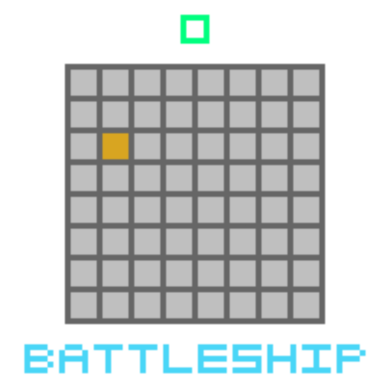

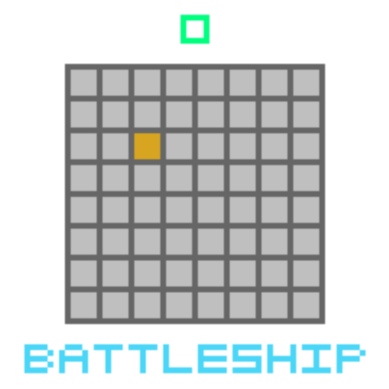

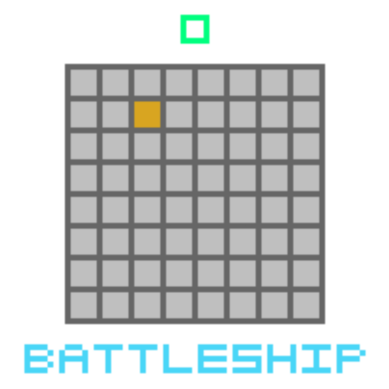

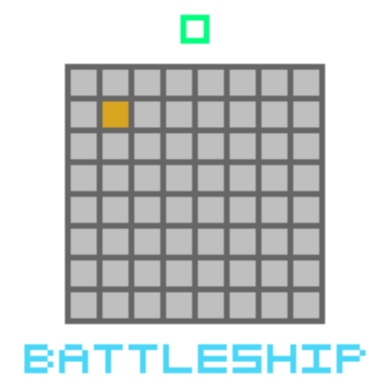

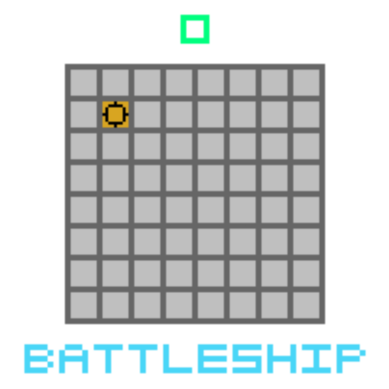

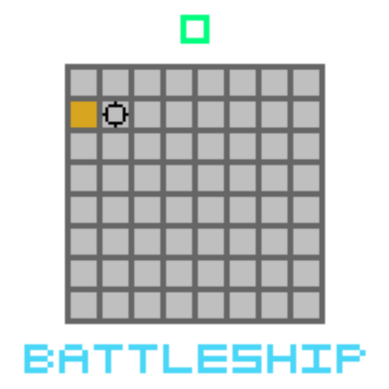

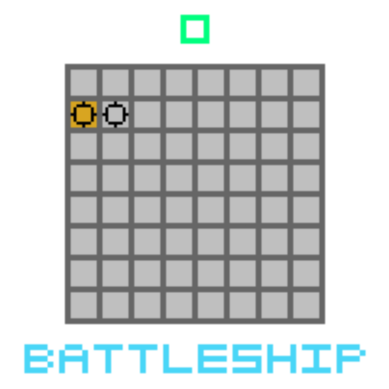

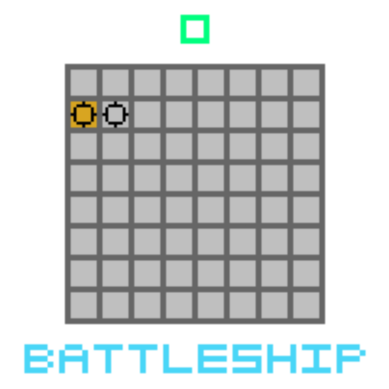

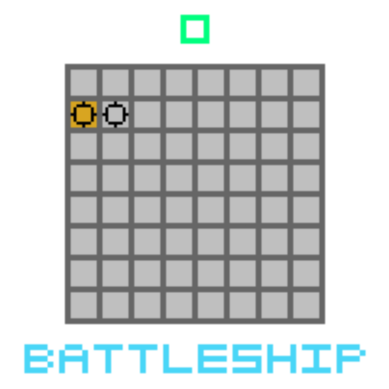

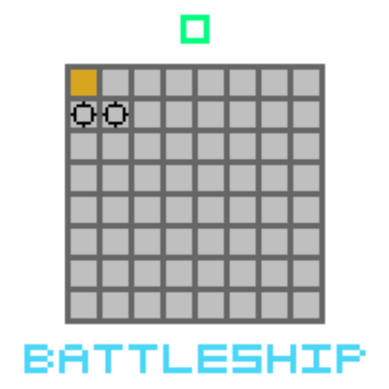

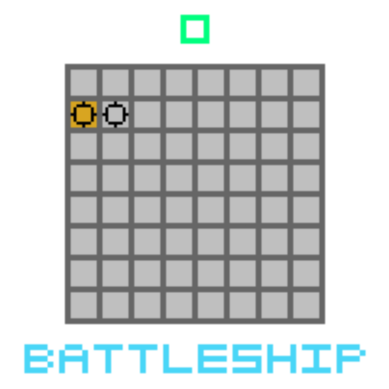

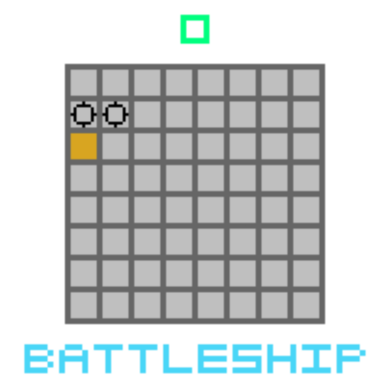

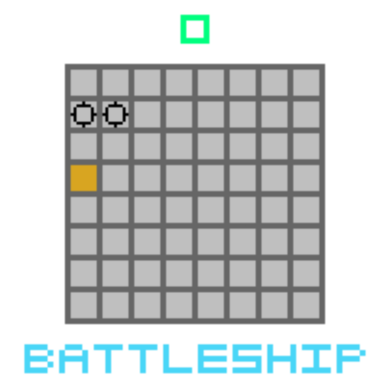

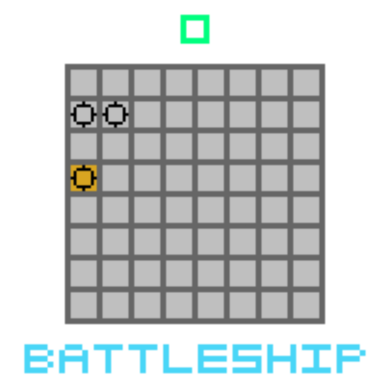

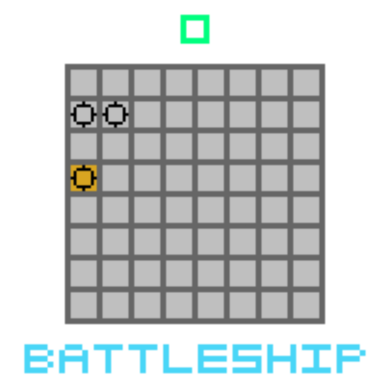

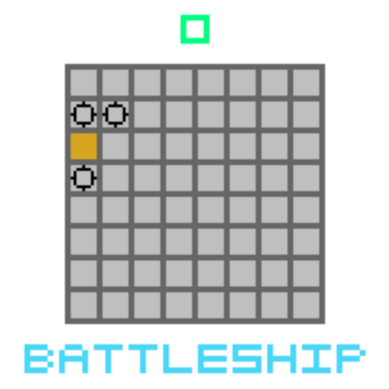

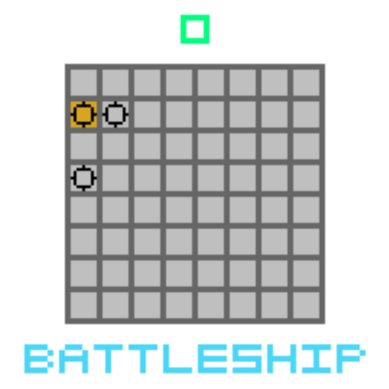

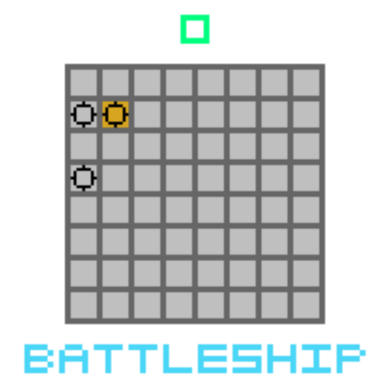

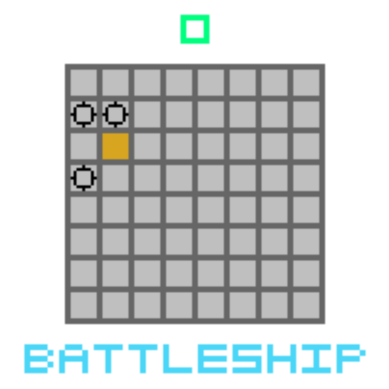

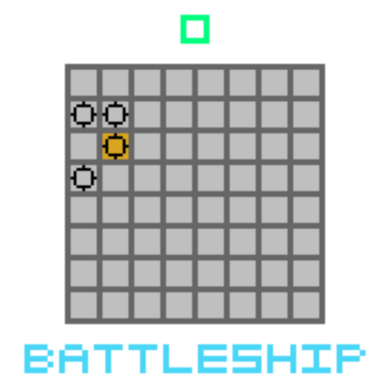

In [1]:
import popgym_arcade
import jax
from matplotlib import pyplot as plt

# Create both POMDP and MDP env variants
pomdp, pomdp_params = popgym_arcade.make("CartPoleEasy", partial_obs=True, obs_size=128)
mdp, mdp_params = popgym_arcade.make("BattleShipEasy", partial_obs=False, obs_size=128)

# Let's vectorize and compile the envs
# Note when you are training a policy, it is better to compile your policy_update rather than the env_step
pomdp_reset = jax.jit(jax.vmap(pomdp.reset, in_axes=(0, None)))
pomdp_step = jax.jit(jax.vmap(pomdp.step, in_axes=(0, 0, 0, None)))
mdp_reset = jax.jit(jax.vmap(mdp.reset, in_axes=(0, None)))
mdp_step = jax.jit(jax.vmap(mdp.step, in_axes=(0, 0, 0, None)))

# Initialize four vectorized environments
n_envs = 4
# Initialize PRNG keys
key = jax.random.key(0)
reset_keys = jax.random.split(key, n_envs)

# Reset environments
observation, env_state = mdp_reset(reset_keys, pomdp_params)

# Step the POMDPs
for t in range(20):
    # Propagate some randomness
    action_key, step_key = jax.random.split(jax.random.key(t))
    action_keys = jax.random.split(action_key, n_envs)
    step_keys = jax.random.split(step_key, n_envs)
    # Pick actions at random
    actions = jax.vmap(pomdp.action_space(pomdp_params).sample)(action_keys)
    # Step the env to the next state
    # No need to reset, gymnax automatically resets when done
    observation, env_state, reward, done, info = mdp_step(step_keys, env_state, actions, pomdp_params)
    plt.axis('off')
    plt.imshow(observation[0])
    plt.show()



# POMDP and MDP variants share states
# We can plug the POMDP states into the MDP and continue playing
action_keys = jax.random.split(jax.random.key(t + 1), n_envs)
step_keys = jax.random.split(jax.random.key(t + 2), n_envs)
markov_state, env_state, reward, done, info = mdp_step(step_keys, env_state, actions, mdp_params)

In [5]:
for i in range(10):
    print(i, i * 8 + 9 * 2)
    print(i, i * 10 + 11 * 2)
    print(i, i * 12 + 13 * 2)

0 18
0 22
0 26
1 26
1 32
1 38
2 34
2 42
2 50
3 42
3 52
3 62
4 50
4 62
4 74
5 58
5 72
5 86
6 66
6 82
6 98
7 74
7 92
7 110
8 82
8 102
8 122
9 90
9 112
9 134
